In [34]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Reading data

In [3]:
epil_df = pd.read_csv('datasets/epil.csv', sep=',')
epil_df.head()

,Unnamed: 0,y,trt,base,age,V4,subject,period,lbase,lage
0,1,5,placebo,11,31,0,1,1,-0.756354,0.114204
1,2,3,placebo,11,31,0,1,2,-0.756354,0.114204
2,3,3,placebo,11,31,0,1,3,-0.756354,0.114204
3,4,3,placebo,11,31,1,1,4,-0.756354,0.114204
4,5,3,placebo,11,30,0,2,1,-0.756354,0.081414


In [4]:
seizure_df = pd.read_csv('datasets/seizure (1).csv', sep=',')
seizure_df['y'] = seizure_df['y1'] + seizure_df['y2'] + seizure_df['y3'] + seizure_df['y4']
seizure_df.head()

,Unnamed: 0,y1,y2,y3,y4,trt,base,age,y
0,1,5,3,3,3,0,11,31,14
1,2,3,5,3,3,0,11,30,14
2,3,2,4,0,5,0,6,25,11
3,4,4,4,1,4,0,8,36,13
4,5,7,18,9,21,0,66,22,55


### Visual exploration

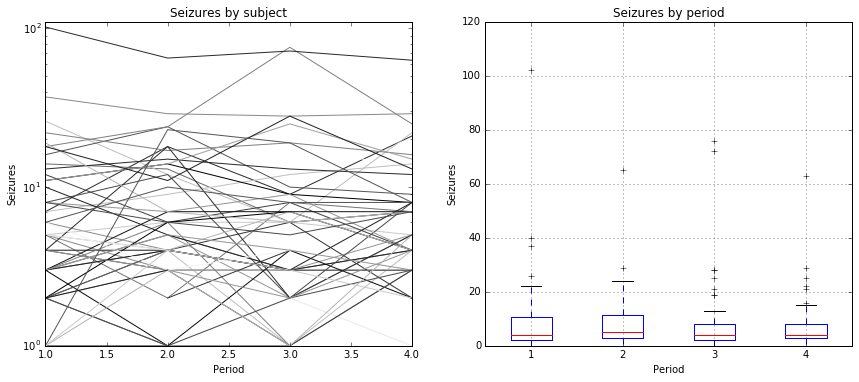

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

min_age, max_age = epil_df['age'].min(), epil_df['age'].max()
age_range = max_age - min_age

for subj_id in set(epil_df['subject'].values):
    subj_df = epil_df[epil_df['subject'] == subj_id]
    color_fac = (float(subj_df['age'].iloc[0]) - min_age) / age_range
    ax[0].semilogy(subj_df['period'], subj_df['y'], color=(color_fac, color_fac, color_fac))
    
ax[0].set_ylim(1, 110)
ax[0].set_title('Seizures by subject')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Seizures')

epil_df[['y', 'period']].boxplot(figsize=(8,8), by='period', ax=ax[1])
ax[1].set_title('Seizures by period')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Seizures')

plt.suptitle('')
plt.show()

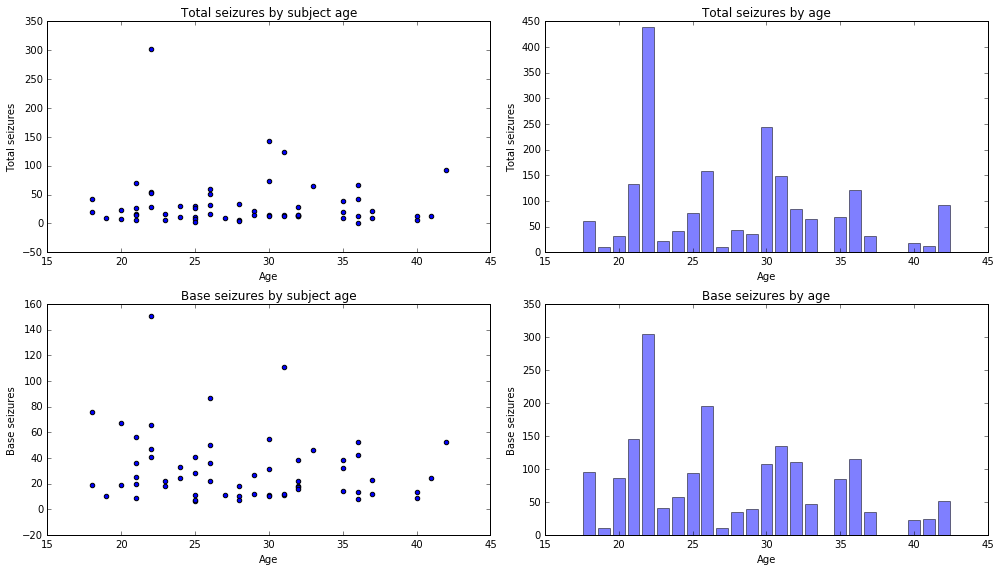

In [6]:
sum_by_subj = epil_df.groupby(['subject']).sum()
counts_by_subj = sum_by_subj['y']
age_by_subj = sum_by_subj['age'] / 4.
base_by_subj = sum_by_subj['base'] / 4.

seizures_by_age =  epil_df.groupby(['age']).sum()['y']
base_by_age = epil_df.groupby(['age']).sum()['base'] / 4.

fig, ax = plt.subplots(2, 2, figsize=(14,8))

ax[0][0].scatter(age_by_subj, counts_by_subj)
ax[0][0].set_xlabel('Age')
ax[0][0].set_ylabel('Total seizures')
ax[0][0].set_title('Total seizures by subject age')

ax[0][1].bar(seizures_by_age.index, seizures_by_age, align='center', alpha=0.5)
ax[0][1].set_xlabel('Age')
ax[0][1].set_ylabel('Total seizures')
ax[0][1].set_title('Total seizures by age')

ax[1][0].scatter(age_by_subj, base_by_subj)
ax[1][0].set_xlabel('Age')
ax[1][0].set_ylabel('Base seizures')
ax[1][0].set_title('Base seizures by subject age')

ax[1][1].bar(seizures_by_age.index, base_by_age, align='center', alpha=0.5)
ax[1][1].set_xlabel('Age')
ax[1][1].set_ylabel('Base seizures')
ax[1][1].set_title('Base seizures by age')

plt.tight_layout()
plt.show()

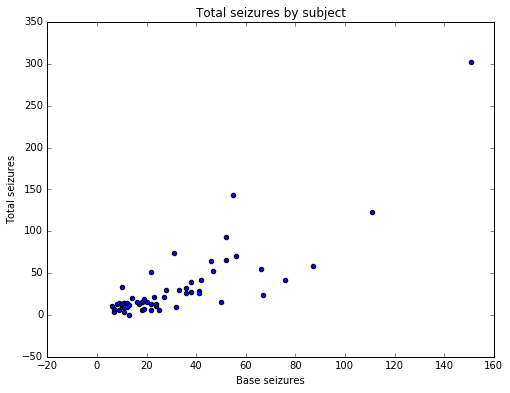

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.scatter(base_by_subj, counts_by_subj)
ax.set_xlabel('Base seizures')
ax.set_ylabel('Total seizures')
ax.set_title('Total seizures by subject')

plt.show()

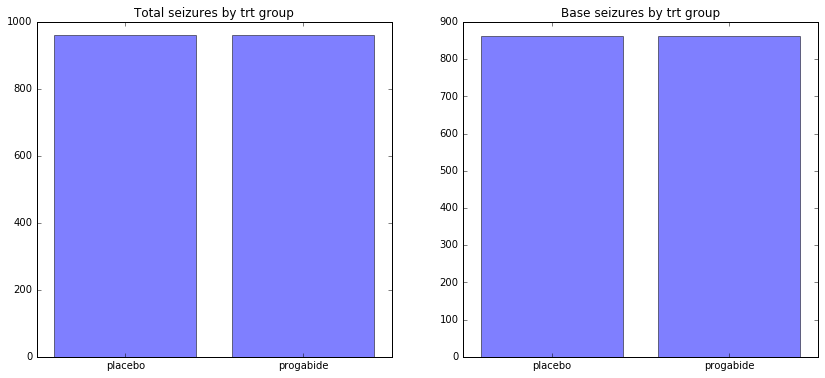

In [8]:
placebo_group = epil_df[epil_df['trt'] == 'placebo']
progabide_group = epil_df[epil_df['trt'] == 'progabide']

seizures_placebo = placebo_group.sum()['y']
seizures_progabide = placebo_group.sum()['y']

base_placebo = placebo_group.sum()['base'] / 4.
base_progabide = placebo_group.sum()['base'] / 4.

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].bar([1, 2], [seizures_placebo, seizures_progabide], align='center', alpha=0.5)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['placebo', 'progabide'])
ax[0].set_title('Total seizures by trt group')

ax[1].bar([1, 2], [base_placebo, base_progabide], align='center', alpha=0.5)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['placebo', 'progabide'])
ax[1].set_title('Base seizures by trt group')

plt.show()

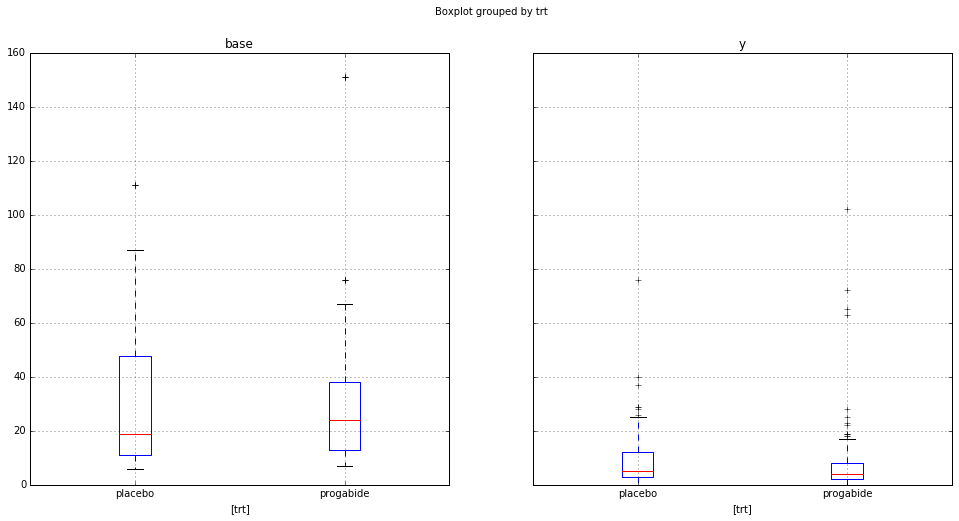

In [9]:
epil_df[['trt', 'y', 'base']].boxplot(figsize=(16,8), by='trt')
plt.show()

### Baseline model

In [15]:
def calculate_model(x_train, y_train, x_test, y_test, x, model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x)
    score_train = model.score(x_train, y_train)
    score_test = model.score(x_test, y_test)
    return score_train, score_test, y_pred

def print_info(title, train_score, test_score):
    print '*** ' + title + ' ***'
    print 'Training score: %.3f' %train_score.mean()
    print 'Testing score: %.3f' %test_score.mean()


In [16]:
x = seizure_df[['trt', 'base', 'age']]

In [43]:
y = seizure_df['y']

n_iter = 100
alphas = 10.**np.arange(-4, 7)
n_alphas = len(alphas)


r_train = np.zeros(n_iter)
r_test = np.zeros(n_iter)
r_train_quad = np.zeros(n_iter)
r_test_quad = np.zeros(n_iter)
lasso_train = np.zeros((n_iter, n_alphas))
lasso_test = np.zeros((n_iter, n_alphas))
ridge_train = np.zeros((n_iter, n_alphas))
ridge_test = np.zeros((n_iter, n_alphas))

for idx in range(n_iter):

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6)
    
    regression = Lin_Reg()
    regression.fit(x_train, y_train)
    r_train[idx] = regression.score(x_train, y_train)
    r_test[idx] = regression.score(x_test, y_test)
    
    quad_features = preprocessing.PolynomialFeatures(degree=2)
    x_train_quad = quad_features.fit_transform(x_train)
    x_test_quad = quad_features.transform(x_test)
    regression.fit(x_train_quad, y_train)
    r_train_quad[idx] = regression.score(x_train_quad, y_train)
    r_test_quad[idx] = regression.score(x_test_quad, y_test)
    
    for j, alpha in enumerate(alphas):
    
        lasso = Lasso_Reg(alpha = alpha)
        lasso.fit(x_train, y_train)
        lasso_train[idx, j] = lasso.score(x_train, y_train)
        lasso_test[idx, j] = lasso.score(x_test, y_test)

        ridge = Ridge_Reg(alpha = alpha)
        ridge.fit(x_train, y_train)
        ridge_train[idx, j] = ridge.score(x_train, y_train)
        ridge_test[idx, j] = ridge.score(x_test, y_test)
    
print_info('Linear regression', r_train, r_test)
print_info('Quadratic regression', r_train_quad, r_test_quad)

*** Linear regression ***
Training score: 0.687
Testing score: 0.269
*** Quadratic regression ***
Training score: 0.803
Testing score: -0.078


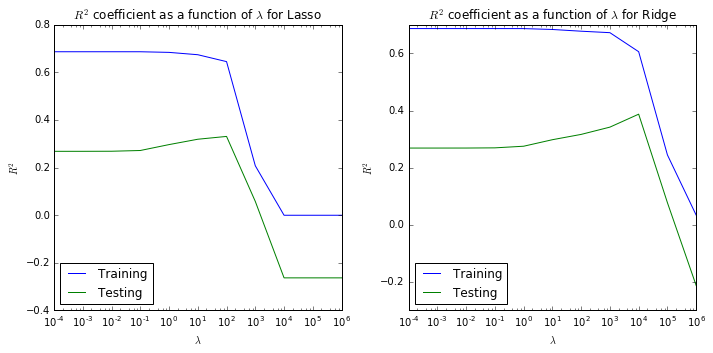

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].semilogx(alphas, lasso_train.mean(axis=0), label='Training')
ax[0].semilogx(alphas, lasso_test.mean(axis=0), label='Testing')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$R^2$')
ax[0].set_title(r'$R^2$ coefficient as a function of $\lambda$ for Lasso')
ax[0].legend(loc=3)

ax[1].semilogx(alphas, ridge_train.mean(axis=0), label='Training')
ax[1].semilogx(alphas, ridge_test.mean(axis=0), label='Testing')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_title(r'$R^2$ coefficient as a function of $\lambda$ for Ridge')
ax[1].legend(loc=3)

plt.tight_layout()
plt.show()